In [1]:
import os
import sys
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

In [14]:
from random import shuffle
def generate_data(corpus, ratio = 0.9):
    shuffle(corpus)
    train_amount = int(len(corpus)*ratio)
    train_target = [corpus[i][1] for i in range(train_amount)]
    train_data = [corpus[i][0] for i in range(train_amount)]
    test_target = [corpus[i][1] for i in range(train_amount, len(corpus))]
    test_data = [corpus[i][0] for i in range(train_amount, len(corpus))]
    return train_data, train_target, test_data, test_target

In [38]:
def purify(str):
    # delete all URLs
    str = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str, flags=re.MULTILINE)
    #delete all usernames
    str = re.sub(r'@\w+', '', str)
    return str.lower()


def learn(classifier):
    train_corpus = []
    for cat in os.listdir("classes"):
        if cat[0] != '.':
            for account in os.listdir("classes/%s" % cat):
                with open("classes/%s/%s" % (cat, account)) as fp:
                    raw_data = csv.reader(fp, delimiter = '|')
                    for line in raw_data:
                        if line[0:1] != "RT":    # ignore retweets
                            train_corpus.append([str(purify(line[3])), cat])

    train_data, train_target, test_data, test_target = generate_data(train_corpus)

    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(train_data)

    tf_transformer = TfidfTransformer()
    X_train_tf = tf_transformer.fit_transform(X_train_counts)

    # here you can specify type of classifier
    
    if classifier == "bayes":
        from sklearn.naive_bayes import MultinomialNB
        text_clf = Pipeline([('vect', CountVectorizer()),
                             ('tfidf', TfidfTransformer()),
                             ('clf', MultinomialNB()), ])
    elif classifier == "knn":
        from sklearn.neighbors import KNeighborsClassifier
        text_clf = Pipeline([('vect', CountVectorizer()),
                             ('tfidf', TfidfTransformer()),
                             ('clf', KNeighborsClassifier()),
                             ])
    elif classifier == "sgdc":
        from sklearn.linear_model import SGDClassifier
        text_clf = Pipeline([('vect', CountVectorizer()),
                             ('tfidf', TfidfTransformer()),
                             ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                                   alpha=1e-3, n_iter=50, random_state=42)),
                             ])
    elif classifier == "svm":
        from sklearn.svm import SVC
        text_clf = Pipeline([('vect', CountVectorizer()),
                             ('tfidf', TfidfTransformer()),
                             ('clf', SVC(kernel="linear")),
                             ])        
    elif classifier == "tree":
        from sklearn.tree import DecisionTreeClassifier
        text_clf = Pipeline([('vect', CountVectorizer()),
                             ('tfidf', TfidfTransformer()),
                             ('clf', DecisionTreeClassifier()),
                             ])
    elif classifier == "deep":
        from sklearn.neural_network import MLPClassifier
        text_clf = Pipeline([('vect', CountVectorizer()),
                             ('tfidf', TfidfTransformer()),
                             ('clf', MLPClassifier(hidden_layer_sizes = (2, 2),
                                                   activation = 'relu',
                                                   solver = "sgd",
                                                   learning_rate = 1
                                                   max_iter = 1000
                                                   verbose = True)),
                             ])
    else:
        from sklearn.linear_model import SGDClassifier
        text_clf = Pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer()),
                            ('clf', SGDClassifier(loss='perceptron', penalty='l2',
                                                     alpha=1e-3, n_iter=5, random_state=42)),
                            ])

    text_clf.fit(train_data, train_target)

    predicted = text_clf.predict(test_data)
    print("Точность модели тематической классификации: ", np.mean(predicted == test_target))   # show quality of model

    joblib.dump(text_clf, 'models/text_model.pkl')     # save working model

    #######
    # Gender recognition

    gender_corpus = []
    for cat in os.listdir("gender"):
        if cat[0] != '.':
            for account in os.listdir("gender/%s" % cat):
                with open("gender/%s/%s" % (cat, account)) as fp:
                    raw_data = csv.reader(fp, delimiter='|')
                    for line in raw_data:
                        if line[0:1] != "RT":  # ignore retweets
                            gender_corpus.append([purify(line[3]), cat])
    gender_data, gender_target, gender_test_data, gender_test_target = generate_data(gender_corpus)
    # no need for setting classifier as perceptron works perfectly well here
#     gender_clf = Pipeline([('vect', CountVectorizer()),
#                            ('tfidf', TfidfTransformer()),
#                            ('clf', SGDClassifier(loss='perceptron', penalty='l2',
#                                                  alpha=1e-3, n_iter=5, random_state=42)),
#                            ])
    gender_clf = text_clf
    gender_clf.fit(gender_data, gender_target)
    predicted = gender_clf.predict(gender_test_data)
    print("Точность модели гендерной классификации: ", np.mean(predicted == gender_test_target))

    joblib.dump(gender_clf, 'models/gender_model.pkl')  # save working model


SyntaxError: invalid syntax (<ipython-input-38-42826dd5ab39>, line 68)

In [28]:
import tweepy
import config
import csv
import sys
import numpy as np
import matplotlib.pyplot as plt
from get_tweets import get_tweets
from collections import Counter
from learn import purify
from sklearn.externals import joblib

auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret)
auth.set_access_token(config.access_key, config.access_secret)
api = tweepy.API(auth)

def classify(username = "medvedevrussia"):
    if len(sys.argv) == 2:
        username = sys.argv[1]
    try:
        text_clf = joblib.load("models/text_model.pkl")
        gender_clf = joblib.load("models/gender_model.pkl")
    except FileNotFoundError:
        sys.exit("Не найден файл модели")
    get_tweets(username, folder="unsorted")
    tweets = []
    with open("unsorted/{0}_tweets.csv".format(username)) as fp:
        raw_data = csv.reader(fp, delimiter='|')
        for line in raw_data:
            if line[0:1] != "RT":  # ignore retweets
                tweets.append(purify(line[3]))

    predicted = text_clf.predict(tweets)
    result = []
    for doc, category in zip(tweets, predicted):
        result.append(category)
    z = Counter(result)
    user = api.get_user(username)
    labels = list(z)
    values = list(z.values())
    explode = [np.log(x) / 50 for x in values]

    plt.pie(values, labels=labels, explode=explode,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')

    print("\n")
    print(user.name, ", ", user.followers_count, "подписчиков.")
    print("Интересы: ")

    for value, label in zip(values, labels):
        print(label, " : %1.1f%%" % (value / len(tweets) * 100))

    gender_predict = gender_clf.predict(tweets)
    gender_result = []
    for doc, category in zip(tweets, gender_predict):
        gender_result.append(category)
    print("Пол: ", Counter(gender_result).most_common()[0][0])
    plt.show()




svm :
Точность модели тематической классификации:  0.683333333333
Точность модели гендерной классификации:  0.610200364299


РИА Новости ,  3176632 подписчиков.
Интересы: 
Правительство и Политика  : 18.5%
Развлечения  : 6.0%
Спорт  : 1.0%
Искусство и Культура  : 8.0%
Новости  : 61.0%
Бренды и Компании  : 2.5%
Музыка  : 3.0%
Пол:  Женщина


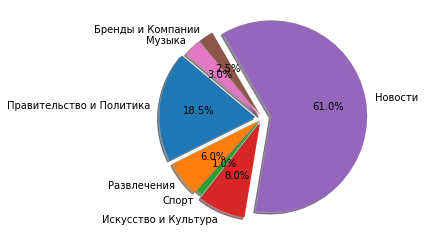

sgdc :
Точность модели тематической классификации:  0.672962962963
Точность модели гендерной классификации:  0.581056466302


РИА Новости ,  3176632 подписчиков.
Интересы: 
Правительство и Политика  : 17.5%
Развлечения  : 13.0%
Спорт  : 3.0%
Искусство и Культура  : 5.5%
Новости  : 43.5%
Бренды и Компании  : 8.0%
Музыка  : 9.5%
Пол:  Женщина


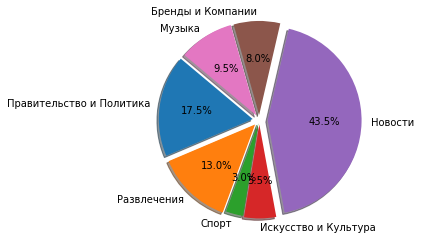

bayes :
Точность модели тематической классификации:  0.674074074074
Точность модели гендерной классификации:  0.613843351548


РИА Новости ,  3176632 подписчиков.
Интересы: 
Правительство и Политика  : 30.5%
Развлечения  : 5.5%
Спорт  : 1.0%
Искусство и Культура  : 4.0%
Новости  : 54.0%
Бренды и Компании  : 0.5%
Музыка  : 4.5%
Пол:  Женщина


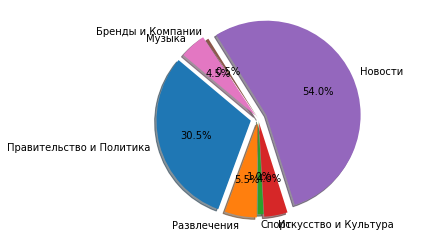

tree :
Точность модели тематической классификации:  0.541481481481
Точность модели гендерной классификации:  0.571948998179


РИА Новости ,  3176633 подписчиков.
Интересы: 
Развлечения  : 23.5%
Правительство и Политика  : 14.5%
Спорт  : 5.0%
Искусство и Культура  : 3.5%
Новости  : 46.5%
Бренды и Компании  : 5.5%
Музыка  : 1.5%
Пол:  Женщина


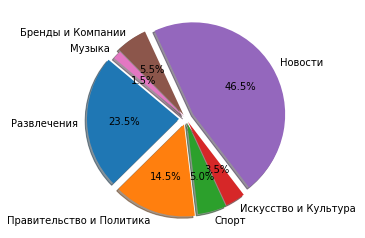

knn :
Точность модели тематической классификации:  0.237777777778
Точность модели гендерной классификации:  0.540983606557


РИА Новости ,  3176633 подписчиков.
Интересы: 
Развлечения  : 28.5%
Правительство и Политика  : 1.5%
Спорт  : 3.5%
Искусство и Культура  : 4.0%
Бренды и Компании  : 42.5%
Музыка  : 20.0%
Пол:  Женщина


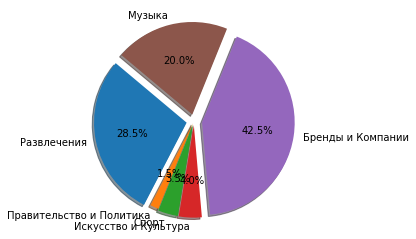

perceptron :
Точность модели тематической классификации:  0.683333333333
Точность модели гендерной классификации:  0.591985428051


РИА Новости ,  3176634 подписчиков.
Интересы: 
Правительство и Политика  : 15.5%
Развлечения  : 11.0%
Спорт  : 2.0%
Искусство и Культура  : 8.0%
Новости  : 49.0%
Бренды и Компании  : 10.0%
Музыка  : 4.5%
Пол:  Мужчина


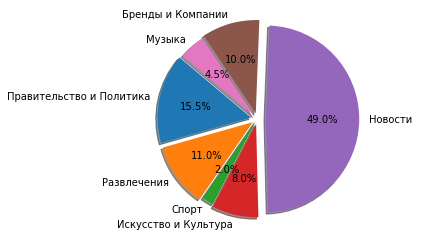

In [20]:
types = ["svm", "sgdc", "bayes", "tree", "knn", "perceptron"]
for clf in types:
    print(clf, ":")
    learn(clf)
    classify("rianru")

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Точность модели тематической классификации:  0.52962962963


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Точность модели гендерной классификации:  0.601092896175


Сталингулаг ,  611750 подписчиков.
Интересы: 
Правительство и Политика  : 34.5%
Развлечения  : 21.0%
Спорт  : 5.0%
Искусство и Культура  : 6.5%
Новости  : 6.5%
Бренды и Компании  : 13.0%
Музыка  : 13.5%
Пол:  Женщина


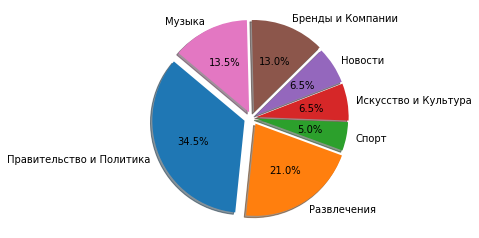

In [39]:
learn("deep")
classify("StalinGulag")



Rick ,  23 подписчиков.
Интересы: 
Развлечения  : 76.5%
Правительство и Политика  : 1.5%
Спорт  : 9.5%
Искусство и Культура  : 3.5%
Новости  : 2.0%
Бренды и Компании  : 2.5%
Музыка  : 4.5%
Пол:  Женщина


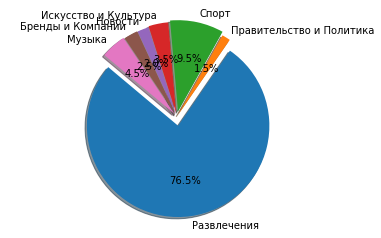

In [22]:
classify("kinamanka")



Марина Капученко ,  98 подписчиков.
Интересы: 
Развлечения  : 71.5%
Правительство и Политика  : 1.5%
Спорт  : 13.0%
Искусство и Культура  : 2.5%
Новости  : 1.0%
Бренды и Компании  : 4.5%
Музыка  : 6.0%
Пол:  Женщина


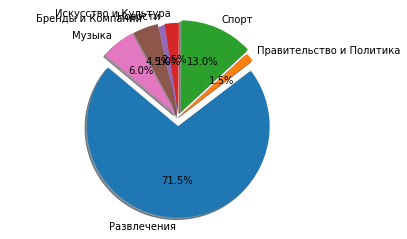

In [23]:
classify("maria_kpstn")



Meduza ,  1029484 подписчиков.
Интересы: 
Правительство и Политика  : 22.0%
Развлечения  : 12.0%
Спорт  : 9.5%
Искусство и Культура  : 4.0%
Новости  : 45.5%
Бренды и Компании  : 2.5%
Музыка  : 4.5%
Пол:  Женщина


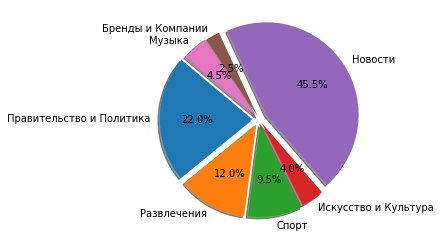

In [24]:
classify("meduzaproject")